In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd

In [2]:
# Pandas display options
pd.set_option('display.max_rows', 1200)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', 100)

In [3]:
# read each dataset in a dataframe
df_abide2 = pd.read_csv('/project/data/ABIDE2/phenotypics.csv')
df_adhd200 = pd.read_csv('/project/data/ADHD200/phenotypics.csv')
df_bhrc = pd.read_csv('/project/data/INPD/phenotypics.csv')
df_abcd = pd.read_csv('/project/data/ABCD/phenotypics.csv')

# ABIDE-II adjusts
df_abide2['dataset'] = 'ABIDE-II'
df_abide2['apd'] = df_abide2['DX_GROUP'].replace(2,0) # any psychiatric disorder
df_abide2 = df_abide2.rename(columns={"SUB_ID": "subjectid", "SEX_BIN": "sex_bin", "AGE_AT_SCAN": "age_y", 
                                      "SITE_ID_BIN": "site"})
# ADHD-200 adjusts
df_adhd200['dataset'] = 'ADHD-200'
df_adhd200['apd'] = df_adhd200['DX'].replace([2,3],1) # any psychiatric disorder
df_adhd200 = df_adhd200.rename(columns={"SCANDIR_ID": "subjectid", "GENDER": "sex_bin", "AGE": "age_y",
                                       "SITE": "site"})
# BHRC adjusts
df_bhrc['dataset'] = 'BHRC'
df_bhrc['gender'] = df_bhrc['gender'].replace(2,0)
df_bhrc['apd'] = df_bhrc['dcany'].replace(2,1) # any psychiatric disorder
df_bhrc = df_bhrc.rename(columns={"gender": "sex_bin", "age": "age_y",
                                  "state": "site"})
# ABCD adjusts
df_abcd['dataset'] = 'ABCD'
df_abcd = df_abcd.rename(columns={"subjectkey": "subjectid", "age": "age_y", "diag_any": "apd",
                                 "scanner_serialnumber_bin": "site"})

# append data to the same dataframe
df = pd.DataFrame()
for dataset in ['df_abide2','df_adhd200','df_bhrc','df_abcd']:
    df = df.append(eval(dataset+"[['dataset','sex_bin','age_y','apd']]"), ignore_index=True)
    
# map gender to a string feature
df['gender'] = np.select([df['sex_bin']==0, df['sex_bin']==1], 
                         ['female', 'male'], 
                         'other')

In [4]:
# get demographic info
list_demogs = []
for dataset in ['ABIDE-II','ADHD-200','BHRC','ABCD']:
    # prepare variables
    condition = df['dataset'] == dataset
    N = df[condition]['gender'].count()
    male_perc = np.round((df[condition & df['sex_bin']==1]['gender'].count() / N), 3)
    female_perc = np.round((1 - male_perc), 3)
    age_mean = np.round(df[condition]['age_y'].mean(), 1)
    age_sd = np.round(df[condition]['age_y'].std(), 1)
    age_range = str(np.round(df[condition]['age_y'].min(), 1)) \
                + '-' \
                + str(np.round(df[condition]['age_y'].max(),1))
    apd_perc = np.round((df[condition & df['apd']==1]['apd'].count() / N),3)
    # prepare dictionary
    demogs = {}
    demogs['dataset'] = dataset
    demogs['N'] = N
    demogs['male_perc'] = male_perc
    demogs['female_perc'] = female_perc
    demogs['age_mean'] = age_mean
    demogs['age_sd'] = age_sd
    demogs['age_range'] = age_range
    demogs['apd_perc'] = apd_perc
    # append dictionary to list
    list_demogs.append(demogs)

# create and show dataframe    
df_demog = pd.DataFrame(list_demogs)
blank_idx = [''] * len(df_demog)  # clear dataframes' indices
df_demog.index = blank_idx
df_demog

,dataset,N,male_perc,female_perc,age_mean,age_sd,age_range,apd_perc
,ABIDE-II,580,0.738,0.262,12.1,3.2,6.1-20.0,0.433
,ADHD-200,922,0.631,0.369,11.7,3.0,7.1-19.9,0.387
,BHRC,737,0.571,0.429,9.9,1.9,5.8-14.3,0.305
,ABCD,11031,0.520,0.480,9.9,0.6,8.9-11.1,0.150


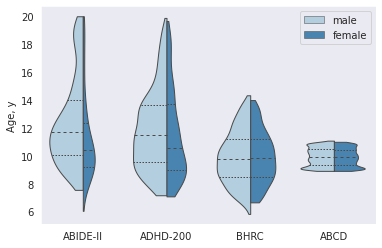

In [8]:
# plot seaborn violin plot
sn.set_style('dark', {'axes.edgecolor': 'white'}) #{"grid.color": ".6", "grid.linestyle": ":"})
ax = sn.violinplot(x='dataset', y='age_y', hue='gender',
                   data=df, palette='Blues', split=True,
                   scale="count", inner="quartile", cut=0, linewidth=1)
ax.set_ylabel("Age, y")
ax.set_xlabel('')
ax.legend().set_title('')
# sn.set_theme(style='whitegrid')
# sns.axes_style()

plt.savefig('/project/sources/violin_plot.png', bbox_inches='tight')


In [9]:
# generate csv files to confound analysis
for dataset in ['ADHD200','ABIDE2','BHRC','ABCD']:
    N = 11 if dataset == 'ABCD' else 6
    task_list = ['AGE','ADHD'] if dataset == 'ADHD200' else ['AGE']
    for task in task_list:
        for i in np.arange(1,N,1):
            # csv filenames
            csv_predictions = '/project/data/results/predictions_csv/' + dataset \
                                + '_'+ task + '_k' + str(i).zfill(2) + '_predictions.csv'
            csv_voxsum = '/project/data/results/predictions_csv/' + dataset \
                            + '_voxels_sum.csv'
            csv_predconfounds = '/project/data/results/predictions_csv/pred_confounds/' + dataset \
                                    + '_' + task + '_k' + str(i).zfill(2) + '_predconfounds.csv'
            # selected columns
            if task == 'AGE':
                columns = ['predicted','target','sex_bin','site','voxels_sum']
                new_columns = ['prediction','target','cnf_cat_sex','cnf_cat_site','cnf_cont_voxsum']
            else:
                columns = ['predicted','target','age_y','sex_bin','site','voxels_sum']
                new_columns = ['prediction','target','cnf_cont_age','cnf_cat_sex','cnf_cat_site','cnf_cont_voxsum']               

            df_predconf = pd.read_csv(csv_predictions)
            df_voxsum = pd.read_csv(csv_voxsum)
            
            # adjust subjectid dtype for dataframe merge
            if dataset == 'ABCD':
                df_predconf['subjectid'] = df_predconf['subjectid'].str.replace("b'","").str.replace("'","").astype(str)
                df_voxsum['subjectid'] = df_voxsum['subjectid'].str.replace("b'","").str.replace("'","").astype(str)
            # merge dataframes and adjust column names
            df_predconf = pd.merge(df_predconf, df_voxsum, on='subjectid')
            df_predconf = pd.merge(df_predconf, eval('df_'+dataset.lower()), on='subjectid')
            df_predconf = df_predconf[columns]
            df_predconf.columns = new_columns
            # save csvs
            df_predconf.to_csv(csv_predconfounds, index=False, na_rep='')
            print(csv_predconfounds) 

/project/data/results/predictions_csv/pred_confounds/ADHD200_AGE_k01_predconfounds.csv
/project/data/results/predictions_csv/pred_confounds/ADHD200_AGE_k02_predconfounds.csv
/project/data/results/predictions_csv/pred_confounds/ADHD200_AGE_k03_predconfounds.csv
/project/data/results/predictions_csv/pred_confounds/ADHD200_AGE_k04_predconfounds.csv
/project/data/results/predictions_csv/pred_confounds/ADHD200_AGE_k05_predconfounds.csv
/project/data/results/predictions_csv/pred_confounds/ADHD200_ADHD_k01_predconfounds.csv
/project/data/results/predictions_csv/pred_confounds/ADHD200_ADHD_k02_predconfounds.csv
/project/data/results/predictions_csv/pred_confounds/ADHD200_ADHD_k03_predconfounds.csv
/project/data/results/predictions_csv/pred_confounds/ADHD200_ADHD_k04_predconfounds.csv
/project/data/results/predictions_csv/pred_confounds/ADHD200_ADHD_k05_predconfounds.csv
/project/data/results/predictions_csv/pred_confounds/ABIDE2_AGE_k01_predconfounds.csv
/project/data/results/predictions_csv/p